# MODELOS SUPERVISADOS

Importación de librerías

In [2]:
import pandas as pd
import numpy as np
import os

from PIL import Image
from matplotlib.image import imread
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, RocCurveDisplay

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping

import pickle

# Importación de X e y

In [3]:
ruta = "../data/exports"

X_flat = np.load(os.path.join(ruta, "X_flat.npy"))

y = np.load(os.path.join(ruta, "y.npy"), allow_pickle=True)

In [4]:
X_flat

array([[  0,   0,   0, ...,   1,   1,   1],
       [  1,   1,   1, ...,   1,   1,   1],
       [107,  81,  56, ..., 166, 133, 114],
       ...,
       [156, 140, 129, ...,  69,  54,  47],
       [ 30,  36,  21, ..., 109, 105, 112],
       [  3,   3,   3, ...,   6,   6,   6]],
      shape=(4000, 12288), dtype=uint8)

In [5]:
X = X_flat
X.shape

(4000, 12288)

In [6]:
y = pd.Series(y)
y

0       angry
1       angry
2       angry
3       angry
4       angry
        ...  
3995      sad
3996      sad
3997      sad
3998      sad
3999      sad
Length: 4000, dtype: object

# Split en train y test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=11)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3600, 12288)
(3600,)
(400, 12288)
(400,)


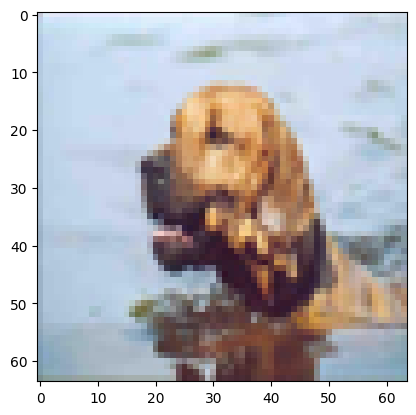

In [7]:
plt.imshow(X_train[0].reshape(64, 64, 3))
plt.show()

# Modelos Supervisados

## RandomForest

In [29]:
rf = RandomForestClassifier(
    random_state=11,
    class_weight='balanced',
    n_jobs=-1
)

parametros = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20],
    "max_features": ["sqrt"],
    "max_leaf_nodes": [None]
}

grid = GridSearchCV(
    rf,
    param_grid=parametros,
    cv=3,                
    scoring="accuracy", 
    verbose=3
)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor accuracy:", grid.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, n_estimators=100;, score=0.403 total time=   5.5s
[CV 2/3] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, n_estimators=100;, score=0.391 total time=   5.3s
[CV 3/3] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, n_estimators=100;, score=0.393 total time=   5.1s
[CV 1/3] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, n_estimators=200;, score=0.407 total time=  10.5s
[CV 2/3] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, n_estimators=200;, score=0.394 total time=  10.6s
[CV 3/3] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, n_estimators=200;, score=0.400 total time=  10.6s
[CV 1/3] END max_depth=20, max_features=sqrt, max_leaf_nodes=None, n_estimators=100;, score=0.412 total time=   7.2s
[CV 2/3] END max_depth=20, max_features=sqrt, max_leaf_nodes=None, n_estimators=100;, score=0.372 total time=   7.0s
[CV 

In [11]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    max_features='log2',
    class_weight='balanced', # correción del desbalanceo de clases
    max_leaf_nodes=None,
    random_state=11,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)

y_pred_proba = rf_model.predict_proba(X_test)

auc_var = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print("Accuracy: ", round(acc, 4))
print("AUC: ", round(auc_var, 4))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))
print("_" * 80)
print("Classification report: \n", classification_report(y_test, y_pred))



Accuracy:  0.3925
AUC:  0.6849
Confusion matrix: 
 [[34 26 27 15]
 [ 2 61 35  3]
 [ 4 50 36  6]
 [20 41 14 26]]
________________________________________________________________________________
Classification report: 
               precision    recall  f1-score   support

       angry       0.57      0.33      0.42       102
       happy       0.34      0.60      0.44       101
     relaxed       0.32      0.38      0.35        96
         sad       0.52      0.26      0.34       101

    accuracy                           0.39       400
   macro avg       0.44      0.39      0.39       400
weighted avg       0.44      0.39      0.39       400



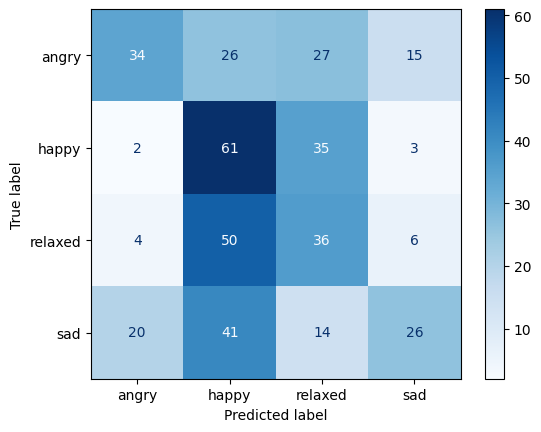

In [12]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["angry", "happy", "relaxed", "sad"])
disp.plot(cmap='Blues')

### Exportación del modelo a formato pickle 

In [14]:
pickle.dump(rf_model, open("../modelos/modelo_randomforest.pkl", "wb"))

In [31]:
modelo_rf = pickle.load(open("../modelos/modelo_randomforest.pkl", "rb"))
modelo_rf

,n_estimators,300
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## KNN

In [18]:
knn_model = KNeighborsClassifier(n_neighbors=3)

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)

y_pred_proba_knn = knn_model.predict_proba(X_test)

auc_knn = roc_auc_score(y_test, y_pred_proba_knn, multi_class='ovr')

print("Accuracy: ", round(acc_knn, 4))
print("AUC: ", round(auc_knn, 4))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_knn))
print("_" * 80)
print("Classification report: \n", classification_report(y_test, y_pred_knn))


Accuracy:  0.3425
AUC:  0.6033
Confusion matrix: 
 [[56 24  9 13]
 [40 26 24 11]
 [31 25 31  9]
 [39 22 16 24]]
________________________________________________________________________________
Classification report: 
               precision    recall  f1-score   support

       angry       0.34      0.55      0.42       102
       happy       0.27      0.26      0.26       101
     relaxed       0.39      0.32      0.35        96
         sad       0.42      0.24      0.30       101

    accuracy                           0.34       400
   macro avg       0.35      0.34      0.33       400
weighted avg       0.35      0.34      0.33       400



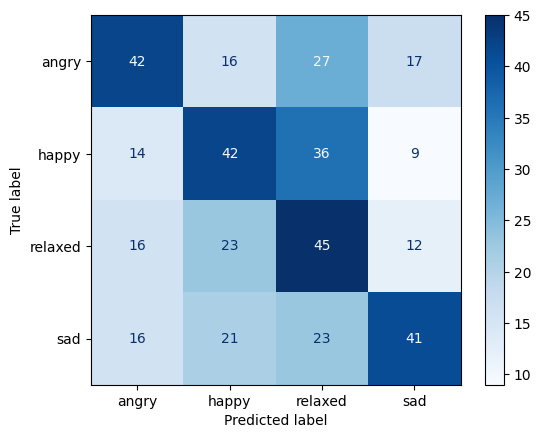

In [26]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=["angry", "happy", "relaxed", "sad"])
disp.plot(cmap='Blues')

In [22]:
knn = KNeighborsClassifier()

parametros = {
    "n_neighbors": [3, 5, 7, 9, 11],       
    "weights": ["uniform", "distance"],    
    "metric": ["euclidean", "manhattan"],  
    "p": [1, 2]                             
}

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=parametros,
    cv=3,                 
    scoring="accuracy",
    verbose=3,
    n_jobs=-1            
)

grid_knn.fit(X_train, y_train)

print("Mejores parámetros:", grid_knn.best_params_)
print("Mejor accuracy:", grid_knn.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Mejor accuracy: 0.38083333333333336


In [28]:
knn_model = KNeighborsClassifier(n_neighbors=9, metric="manhattan", p=1, weights="distance")

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)

y_pred_proba_knn = knn_model.predict_proba(X_test)

auc_knn = roc_auc_score(y_test, y_pred_proba_knn, multi_class='ovr')

print("Accuracy: ", round(acc_knn, 4))
print("AUC: ", round(auc_knn, 4))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_knn))
print("_" * 80)
print("Classification report: \n", classification_report(y_test, y_pred_knn))


Accuracy:  0.425
AUC:  0.6866
Confusion matrix: 
 [[42 16 27 17]
 [14 42 36  9]
 [16 23 45 12]
 [16 21 23 41]]
________________________________________________________________________________
Classification report: 
               precision    recall  f1-score   support

       angry       0.48      0.41      0.44       102
       happy       0.41      0.42      0.41       101
     relaxed       0.34      0.47      0.40        96
         sad       0.52      0.41      0.46       101

    accuracy                           0.42       400
   macro avg       0.44      0.43      0.43       400
weighted avg       0.44      0.42      0.43       400



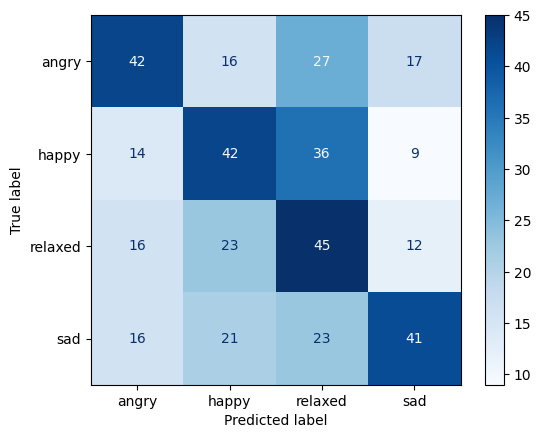

In [29]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=["angry", "happy", "relaxed", "sad"])
disp.plot(cmap='Blues')

### Exportación del modelo a formato pickle 

In [30]:
pickle.dump(knn_model, open("../modelos/modelo_knn.pkl", "wb"))

In [33]:
modelo_knn = pickle.load(open("../modelos/modelo_knn.pkl", "rb"))
modelo_knn

,n_neighbors,9
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,1
,metric,'manhattan'
,metric_params,None
,n_jobs,None
